In [ ]:
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: astropy
    Found existing installation: astropy 5.2.2
    Uninstalling astropy-5.2.2:
      Successfully uninstalled astropy-5.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.1/978.1 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyregion: filename=pyregion-2.2.0-cp310-cp310-linux_x86_64.whl size=364696 sha256=537215495297b9a05f6e120facf15ce427c5ef730b526da73206721186e56bb2
  Stored in directory: /root/.cache/pip/wheels/d9/70/ba/133c9854fc976d08620a301e977d089103a5bf96cc55f68224
Successfully built pyregion
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pyregion
from astropy.coordinates import Angle
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS

First we mount the drive to the notebook file and then we set the path for the files we will be using

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pathd = '/content/drive/MyDrive/Codes/'

Mounted at /content/drive


## Reading and Plotting FITS files

In [ ]:
nfile = 'Galaxyfits/NGC5258_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits'

Fetch the FITS file from directory

In [ ]:
image = fits.open('/content/drive/MyDrive/Codes/Galaxyfits/NGC5258_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits')[0]
image_header = image.header

Creating a WCS object from the FITS header in order to use as a projection argument when plotting the image in equatorial coordinates

In [ ]:
wcs_galaxy = WCS(image_header)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


Plotting the image

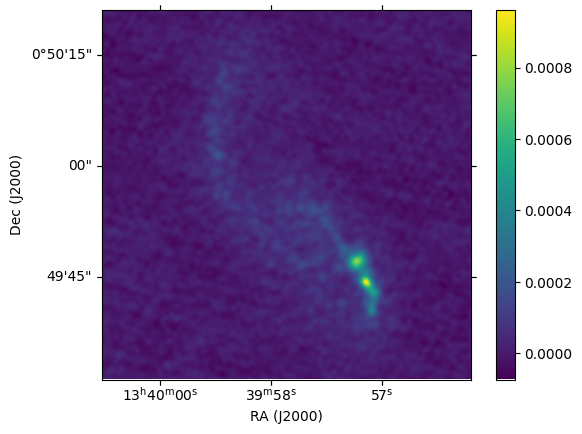

In [ ]:
fig = plt.figure()
ax = plt.subplot(projection=wcs_galaxy)
plt.imshow(image.data, origin='lower', cmap='viridis')
plt.xlabel(r'RA (J2000)')
plt.ylabel(r'Dec (J2000)')
plt.colorbar()

Data displayed in the image avobe corresponds to flux density (Jy/beam), if we want to plot Luminosity instead, we can do the conversion of the data, since it is storaged as a mutidimensional numpy array

In [ ]:
L      = image.data / (4*np.pi*(10000)**2)
L_data = L / (1.828*10**26) #conversion to solar luminosity

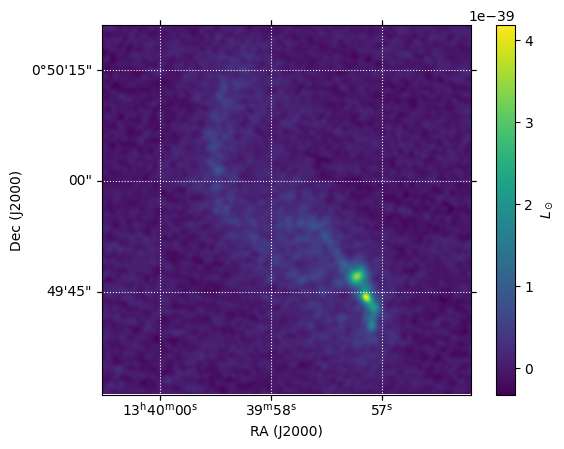

In [ ]:
fig = plt.figure()
ax = plt.subplot(projection=wcs_galaxy)
plt.imshow(L_data, origin='lower', cmap='viridis')
plt.xlabel(r'RA (J2000)')
plt.ylabel(r'Dec (J2000)')
cbar = plt.colorbar()
cbar.set_label('$L_\odot$')
plt.grid(color='white', ls='dotted')

## Working with Regions

You can load a predetermined region using the `pyregion.open()` or the `pyregion.parse()` methods, in this case since we have ds9 generated regions in .reg format we can use the first one. Note that we also add `as_imagecoord()` since it loads the image in a fk5 coordinate format by default, so we need to specify that we want to use the coord format that is in the FITS header

In [ ]:
region1 = pyregion.open(pathd + 'Regions/brightclump1.reg').as_imagecoord(image_header)
region2 = pyregion.open(pathd + 'Regions/noisyclump1.reg').as_imagecoord(image_header)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


In [ ]:
region1[0].coord_format #checking the coordinates format

'image'

Creating a mask for each of the two regions

In [ ]:
mask1 = region1.get_mask(shape=L_data.shape)
mask2 = region2.get_mask(shape=L_data.shape)

Plotting the regions

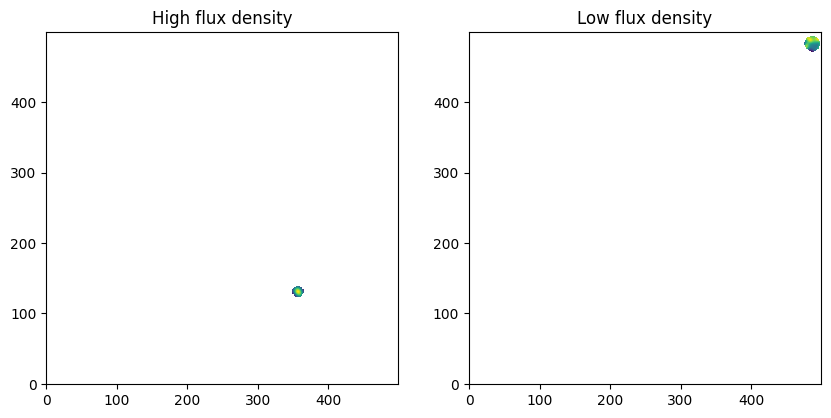

In [ ]:
masked_image_1 = np.ma.masked_array(image.data, mask=~mask1)
masked_image_2 = np.ma.masked_array(image.data, mask=~mask2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(masked_image_1, origin='lower')
ax1.set_title('High flux density area')
ax2.imshow(masked_image_2, origin='lower')
ax2.set_title('Low flux density area')
# plt.imshow(masked_image_1, origin='lower')
plt.show()

Applying the mask to the image in order to get the information contained in the masked region. Then calculating the total flux density in those regions

In [ ]:
masked_data1 = image.data * mask1
masked_data2 = image.data * mask2

In [ ]:
total_flux_density1 = np.sum(masked_data1)*u.Jy/u.beam
total_flux_density1

<Quantity 0.16003299 Jy / beam>

In [ ]:
total_flux_density2 = np.sum(masked_data2)*u.Jy/u.beam
total_flux_density2

<Quantity 0.00296209 Jy / beam>

Note that the first masked data corresponds to the brighter clumps of the image, therefore it has a greater total flux density than the second region that corresponds to an area containing only noise

## Noise Characterization

If we average the values of the flux density among the only-noise regions per beam we obtain what is called the rms of the image

Working with one circular region we can estimate its rms

In [ ]:
bmajor = image_header['BMAJ']*3600*u.arcsec #in arcsec
bminor = image_header['BMIN']*3600*u.arcsec #in arcsec
bpa = image_header['BPA']

beam_area = np.pi*bmajor*bminor/(4*np.log(2)) #area of a single beam

#Calculating the area of the aperture
radius2 = region2[0].coord_list[2]*2.777777777778E-05*3600*u.arcsec
# radius2_rad = np.deg2rad(radius2)*u.arcsec
aperture_area2 = np.pi * radius2**2

nbeams = aperture_area2/beam_area

rms = total_flux_density2 / nbeams
rms

<Quantity 0.00071543 Jy / beam>

Working with a multiple-aperture reg file

In [ ]:
regionn = pyregion.open(pathd + 'Regions/noise3').as_imagecoord(image_header)

In [ ]:
def rpicker(num):
  return regionn[num]

In [ ]:
rpicker(12)

Shape : circle ( Number(39),Number(184),Number(24.192058) )

In [ ]:
masked_datas = []

In [ ]:
# for i in range(0,12):
#   mask_n = ([rpicker(i)]).get_mask(shape=L_data.shape)
#   masked_data_n = image.data * mask_n
#   masked_datas.append(masked_data_n)

Applying sigma clipping to the data

In [ ]:
data = image.data
sigma_clip = SigmaClip(sigma=2.0)
bkgrms = StdBackgroundRMS(sigma_clip)

In [ ]:
bkgrms_value = bkgrms.calc_background_rms(data)
print(bkgrms_value)

1.6937567e-05


Plotting the image with contours at 3, 5 and 10 $\sigma$

In [ ]:
# !pip install cartopy;
# import cartopy.crs as ccrs

Text(0, 0.5, 'Dec (J2000)')

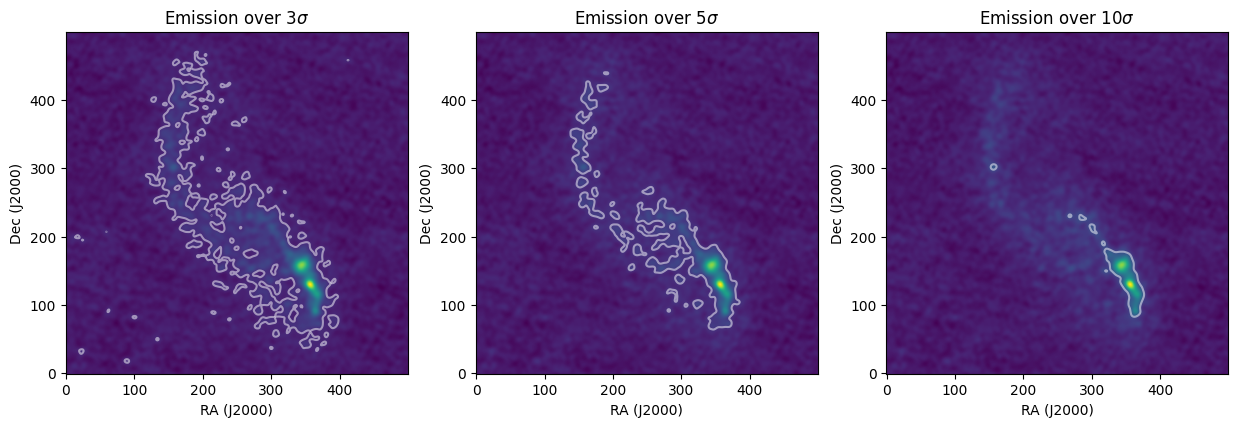

In [ ]:
figs, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

# plt.subplot(projection=wcs_galaxy)
ax1.imshow(image.data, origin='lower', cmap='viridis')
ax1.contour(image.data, levels=np.linspace(3*bkgrms_value, 500, 1), colors='white', alpha=0.5)
ax1.set_title('Emission over 3$\sigma$')
ax1.set_xlabel(r'RA (J2000)')
ax1.set_ylabel(r'Dec (J2000)')

# plt.subplot(projection=wcs_galaxy)
ax2.imshow(image.data, origin='lower', cmap='viridis')
ax2.contour(image.data, levels=np.linspace(5*bkgrms_value, 500, 1), colors='white', alpha=0.5)
ax2.set_title('Emission over 5$\sigma$')
ax2.set_xlabel(r'RA (J2000)')
ax2.set_ylabel(r'Dec (J2000)')

# plt.subplot(projection=wcs_galaxy)
ax3.imshow(image.data, origin='lower', cmap='viridis')
ax3.contour(image.data, levels=np.linspace(10*bkgrms_value, 500, 1), colors='white', alpha=0.5)
ax3.set_title('Emission over 10$\sigma$')
ax3.set_xlabel(r'RA (J2000)')
ax3.set_ylabel(r'Dec (J2000)')


# ax = plt.subplot(projection=wcs_galaxy)
# plt.imshow(image.data, origin='lower', cmap='viridis')

We can calculate the emission flux over 3$\sigma$

First we create an array that contains all of the flux density values over our rms theshold, also we get the number of pixels containing such data.

In [ ]:
fluxden_over3s = image.data [image.data > 3*bkgrms_value]*u.Jy/u.beam
pixels_over_3s = len(flux_over3s)

We need to convert the ammount of pixels to the ammount of beams in the region and then multiply it with the intensity in order to get the flux

In [ ]:
pixel_area = (image_header['CDELT1']*3600*u.arcsec)**2
total_area_over_3s = pixels_over_3s * pixel_area

In [ ]:
beams_over_3s = (total_area_over_3s / beam_area)*u.beam
beams_over_3s

<Quantity 273.32338147 beam>

Calculating the flux over 3$\sigma$

In [ ]:
flux_over_3s = sum(fluxden_over3s)*beams_over_3s
flux_over_3s

<Quantity 879.18981411 Jy>

## Appendix Code

In [ ]:
# !pip install radio-beam
# from radio_beam import Beam

In [ ]:
header2 = image_header

In [ ]:
beam_area_formula = np.pi*bmajor*bminor/(4*np.log(2))

my_beam = Beam.from_fits_header(header2)
header2.update(my_beam.to_header_keywords())
beam_area_astropy = my_beam.sr

print(beam_area_formula,'sr', beam_area_astropy)

In [ ]:
regionn[12]

In [ ]:
image_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
BMAJ    =   2.777777777778E-04                                                  
BMIN    =   2.777777777778E-04                                                  
BPA     =   0.000000000000E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'NGC 5257/8'                                                          
BUNIT   = 'Jy/beam '           /Brightness (pixel) unit                         
EQUINOX =   2.000000000000E+03                                                  
RADESYS = 'FK5     '        

In [ ]:
np.max(image.data)

0.0009615083